In [2]:
import torch
import csv
import numpy as np
%matplotlib ipympl
import matplotlib.pyplot as plt
from scipy.sparse import coo_matrix
import torch
from torch.optim import Adam
from torch.optim import SGD
import torch.nn as nn
plt.ion()

In [3]:
filename = "simple-data.txt" # replace with your file name

material_names_to_ids = {}
coefficient_data = []

num_materials = 0
with open(filename, 'r') as file:
    reader = csv.reader(file, delimiter='\t')
    for row in reader:
        def get_id(name):
            global num_materials
            if name not in material_names_to_ids:
                material_names_to_ids[name] = num_materials
                num_materials = num_materials+1
            return material_names_to_ids[name]
        coefficient_data.append((get_id(row[0]),get_id(row[1]),float(row[2])))

In [4]:
# extract the row indices, column indices, and values from the triplets
rows = [t[0] for t in coefficient_data]
cols = [t[1] for t in coefficient_data]
vals = [t[2] for t in coefficient_data]
# create a sparse matrix in COO format
coefficient_matrix = coo_matrix((vals, (rows, cols)),shape=(num_materials,num_materials))

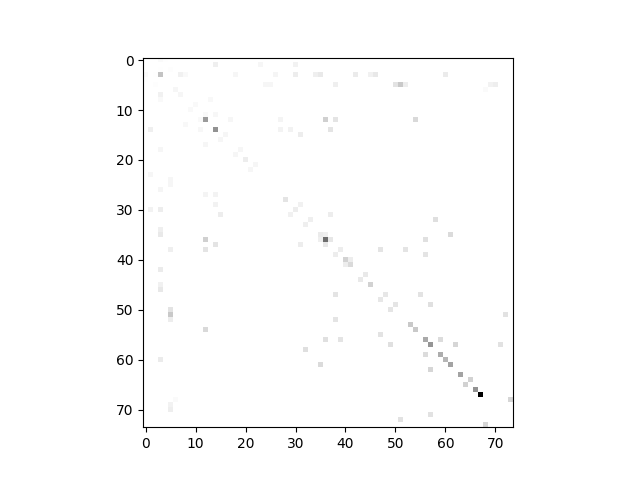

In [5]:
# plot the sparsity pattern
plt.imshow((coefficient_matrix+coefficient_matrix.T).todense(), cmap='binary', interpolation='nearest')
plt.show()

In [6]:
# define the initial values of z[i] and z[j]
log_z = torch.rand(num_materials, 1, requires_grad=True)

In [7]:
# define the optimizer
#optimizer = Adam([log_z], lr=0)# define the loss function
optimizer = SGD([log_z], lr=0.01, momentum=0.9)

In [8]:
class SimpleNet(nn.Module):
    def __init__(self):
        super(SimpleNet, self).__init__()
        self.layer1 = nn.Linear(3, 8) # input layer -> hidden layer 1
        #self.layer2 = nn.Linear(20, 20) # hidden layer 1 -> hidden layer 2
        #self.layer3 = nn.Linear(20, 20) # hidden layer 2 -> hidden layer 3
        self.layer4 = nn.Linear(8, 1) # hidden layer 3 -> output layer
        self.relu = nn.ReLU() # ReLU activation function

    def forward(self, x):
        x = self.relu(self.layer1(x))
        #x = self.relu(self.layer2(x))
        #x = self.relu(self.layer3(x))
        x = self.layer4(x)
        return x

In [9]:
def geomean(zi,zj):
    return torch.sqrt(zi * zj)


def f(zi,zj):
    #model = SimpleNet()
    #return model.forward(torch.tensor([zi, zj, geomean(zi,zj)], requires_grad=True))
    return geomean(zi,zj)

def loss_function(triplets, log_z):
    loss = 0
    z = torch.exp(log_z)
    for i, j, v in triplets:
        loss += ( f(z[i],z[j]) - v)**2
    return loss

In [10]:
# perform the optimization
num_epochs = 100000
#batch_size = 1
batch_size = len(coefficient_data)
for epoch in range(num_epochs):
    if epoch % 100 == 0:
        print(f"%d: %g (%g,%g)" % (epoch,loss_function(coefficient_data,log_z)/len(coefficient_data),torch.min(log_z),torch.max(log_z)))
    # shuffle the triplets for each epoch
    np.random.shuffle(coefficient_data)
    # iterate over mini-batches
    #for i in range(0, len(coefficient_data), batch_size):
    for i in [1]:
        batch_triplets = coefficient_data[i:i+batch_size]
        optimizer.zero_grad()
        loss = loss_function(batch_triplets, log_z)
        loss.backward()
        optimizer.step()    
    
# print the final values of z
#print(torch.exp(log_z).detach().numpy())

0: 2.04912 (0.00271517,0.983518)
100: 0.0449645 (-7.73555,0.463768)
200: 0.0306586 (-7.10115,0.55348)
300: 0.0234487 (-6.14643,0.614886)
400: 0.0186865 (-4.4113,0.715614)
500: 0.0102092 (-3.45555,0.955858)
600: 0.0082369 (-3.5252,0.732926)
700: 0.00699021 (-3.57362,0.761996)
800: 0.00640383 (-3.60854,0.787816)
900: 0.00612161 (-3.63432,0.811558)
1000: 0.00598059 (-3.65236,0.832937)
1100: 0.00587729 (-3.6666,0.853641)
1200: 0.00581831 (-3.67712,0.873157)
1300: 0.00577623 (-3.73703,0.891774)
1400: 0.00574748 (-3.83909,0.909371)
1500: 0.00572649 (-3.93024,0.926759)
1600: 0.00571198 (-4.01158,0.94344)
1700: 0.00569021 (-4.08622,0.959627)
1800: 0.00567703 (-4.15449,0.975472)


KeyboardInterrupt: 

In [17]:
def plot(f,z):
    global coefficient_data
    x = np.linspace(0,np.max(z),20)
    y = np.linspace(0,np.max(z),20)
    X, Y = np.meshgrid(x, y)
    Z = np.zeros(X.shape)
    for i in range(X.shape[0]):
        for j in range(X.shape[0]):
            Z[i,j] = f(torch.tensor(X[i,j]),torch.tensor(Y[i,j]))
    
    fig = plt.figure()
    ax = fig.add_subplot(111,projection='3d')
    ax.plot_surface(X,Y,Z)
    
    
    indices = np.array([(i, j) for (i, j, v) in coefficient_data])
    values = np.array([v for (i, j, v) in coefficient_data])

    # extract the coordinates from z using the indices
    #x = z[indices[:, 0]]
    #y = z[indices[:, 1]]
    #z = values
    #ax.scatter(x, y, z, color='orange')

    # Make the plot interactive with mouse rotation
    #ax.view_init(elev=30, azim=120)
    #ax.dist = 10
    #ax.mouse_init()
    plt.show()
    

In [18]:
plot(f,torch.exp(log_z).detach().numpy())

In [19]:
torch.exp(log_z)

In [30]:
print("x")